In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import PIL
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from itertools import chain

import numpy
import scipy.cluster.hierarchy as hcluster

# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook
from scipy.signal import find_peaks
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp


m_p=1
Fps=1



### function to find msd, returns list of msd values and plots the individual particles msds when called

def find_msd(data,max_lag_time):  ## takes in dataframe and a max lag time
    matrix_msd=[] ## to store all particle trajectories (each row a particle trajectory)
    d_t=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        for t in range(1,max_lag_time):  ## loop over lag times
            del_t.append(t)
            dx=[(x_list[j+t]-x_list[j]) for j in range(len(x_list)-int(max_lag_time))]
            dy=[(y_list[j+t]-y_list[j]) for j in range(len(y_list)-int(max_lag_time))]
            disp=[np.sqrt(dx[i]**2+dy[i]**2) for i in range(len(dx))] ## find displacement
            msd_temp=np.mean(disp)## mean 
            msd_part_i.append(msd_temp)
        #plt.loglog(del_t,msd_part_i,alpha=0.1,color='black')
        matrix_msd.append(msd_part_i)
        d_t.append(del_t)
        plt.xlabel('lag_time')
        plt.ylabel('msd')
        
        #plt.show() ###shows individual particle msds while calling the function
    matrix_msd_arr = np.array(matrix_msd)
    # delete all the rows with any NaN value( some rows become nan as there are too less trajectory frames compared to max lag time)
    indexList = [np.any(i) for i in np.isnan(matrix_msd_arr )]
    matrix_msd_corrected  = np.delete(matrix_msd_arr , indexList, axis=0)
    msd = np.average(matrix_msd_corrected, axis=0)  ## average columns of the matrix(ie over all positions for a lag time)
    return msd,del_t
    
def find_traj_data(frames,conect,mem,size,mass,filt):
    ## locate features in all frames( fluroscent bleach after 200 frames)
    f = tp.batch(frames[:len(frames)],size, minmass=mass); ### locate features with radius 7 and minimum brightness 100 from frame 100

    ## link different frames
    t = tp.link(f,conect, memory=mem) ### features must uptot 5 pixels in the next frame to be considered a trajectory (memory incase it disapears for some frames)

    #### trajectories that last fewer than 30 frames are disguarded
    t1 = tp.filter_stubs(t,filt)
    # Compare the number of particles in the unfiltered and filtered data.
    #print('Before:', t['particle'].nunique())
    #print('After:', t1['particle'].nunique())

     #tp.plot_traj(t1);

    ## subtract any drift in image(look at image from the center of mass)
    d = tp.compute_drift(t1)
    tm = tp.subtract_drift(t1.copy(), d) 
    tm.rename(columns = {'size':'area'}, inplace = True)
    data = pd.DataFrame()

    for item in set(tm.particle):
    
        sub = tm[tm.particle==item]
    
        dx = m_p*np.diff(sub.x)/1. # differnece between to frame for X postion
        dy = m_p*np.diff(sub.y)/1. #wdiffernece between to frame for Y postion
        dt = np.diff(sub.frame)/Fps #to calcul the time
        dr=((np.sqrt(dy**2 + dx**2)))
        tan = (dy/dx) # to calcul the slope
        ang_d=abs((np.arctan(tan)*57.2958))
        #print(np.diff(sub.frame))
        v = (((np.sqrt(dy**2 + dx**2)))/dt) # to calcul the velocity  12 microns per pixel
        for x, y, dx, dy,disp, v,ang_disp,area, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy),dr ,v,ang_d,sub.area[:-1] ,dt,sub.frame[:-1],):
            data = data.append([{'dx': dx,
            'dy': dy,
             'x': x,
             'y': y,
            'frame': frame,
             'particle': item,
              'disp':disp,                  
             'dt' : dt,
             'area':area,
              'ang_disp':ang_disp,                   
             'v' : v,}])
       
    ## correct angles based on a cartesian plane convert to radian
    ang_list=list(data['ang_disp'])
    dx_list=list(data['x'])
    dy_list=list(data['y'])
    #print(dx_list)
    #69.123*0.0174533
    ang_d_corrected=[]  
    for i in range(0,len(ang_list)):
        if dx_list[i]>0 and dy_list[i]>0:
            ang_d_corrected.append((ang_list[i])*0.0174533)
        if dx_list[i]<0 and dy_list[i]>0:
            ang_d_corrected.append((180-ang_list[i])*0.0174533)
        if dx_list[i]<0 and dy_list[i]<0:
            ang_d_corrected.append((180+ang_list[i])*0.0174533)
        if dx_list[i]>0 and dy_list[i]<0:
            ang_d_corrected.append(((360-ang_list[i])*0.0174533))
    data['ang_corr']=ang_d_corrected
    
    utraj = np.unique(tm.particle)
    num_traj = utraj.size
    cdict = {}

   # fig, ax = plt.subplots(figsize=(8,8))
   # ax.cla()
    #for i in range(num_traj):
    #    iid = tm.particle == utraj[i]
    #    xi = np.array(tm.x[iid])
     #   yi = np.array(tm.y[iid])
        # print(xi.shape)
    
      #  if (xi.size > 0):
      #      plt.plot(xi,yi,'-',ms=2,lw=0.5)
       #     p = ax.plot(xi,yi,'-',ms=2,lw=0.5)
         #   color = p[0].get_color()
         #   cdict[utraj[i]] = color 
          #  plt.plot(xi[xi.size-1],yi[xi.size-1],'o',ms=4,c=color,markerfacecolor='w',lw=0.5)
    return tm,data
%matplotlib notebook
def find_ee_distance(data):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    xi=[]
    yi=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dx=(x_list[0]-x_list[-1])
        dy=(y_list[0]-y_list[-1])
        disp=np.sqrt(dx**2+dy**2) ## find displacement
        disp_part_i.append(disp)
        xi.append(x_list[-1])
        yi.append(y_list[-1])
        part_id.append(i)
    return disp_part_i,xi,yi,part_id

def find_rad_distance(data,xc,yc):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    ri_list=[]
    rf_list=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dxi=(x_list[0]-xc)
        dyi=(y_list[0]-yc)
        dxf=(x_list[-1]-xc)
        dyf=(y_list[-1]-yc)  
        ri=np.sqrt(dxi**2+dyi**2) ## find displacement
        rf=np.sqrt(dxf**2+dyf**2) ## find displacement
        ri_list.append(ri)
        rf_list.append(rf)
        part_id.append(i)
    return ri_list,rf_list,part_id

def in_out(min_dist,ri,rf,xe,ye,ee,iidr,data,frames):
    iid_in=[]
    iid_out=[]
    for i in range(0,len(ri)):
        
        if ri[i]>rf[i] and ee[i]>min_dist:
            plt.scatter(xe[i],ye[i],color='yellow',s=20)
            df=data.loc[data['particle'] ==iidr[i]]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            plt.plot(trajx,trajy,color='brown')
            iid_in.append(i)
        if ri[i]<rf[i] and ee[i]>min_dist:
            plt.scatter(xe[i],ye[i],color='cyan',s=20)
            df=data.loc[data['particle'] ==iidr[i]]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            plt.plot(trajx,trajy,color='brown')
            iid_out.append(i)
         #plt.ylim(max(ye), min(ye))

    plt.plot()
    plt.imshow(frames[0]);
    ratio_in_out=len(iid_in)/(len(iid_out)+len(iid_in))
    
    return ratio_in_out

def find_cm(frames,tm,size):
    ##finding center of cell, is taking center of mass ok? how to define the center from image?
    f = tp.batch(frames[:200],size, minmass=100); ### locate features with radius 7 and minimum brightness 100 from frame 100
    x_vals=f['x'].tolist()
    y_vals=f['y'].tolist()
    mass=f['raw_mass'].tolist()
    x_cm=0
    y_cm=0
    for i in range(0,len(mass)):## takin
        x_cm+=(x_vals[i]*mass[i])/np.sum(mass)
        y_cm+=(y_vals[i]*mass[i])/np.sum(mass)
    
     
    return x_cm,y_cm
def pot_traj(data,frame):
    df=data.loc[data['frame'] ==frame]
    x_list=df['x'].tolist()
    y_list=df['y'].tolist()
    return x_list,y_list

<IPython.core.display.Javascript object>


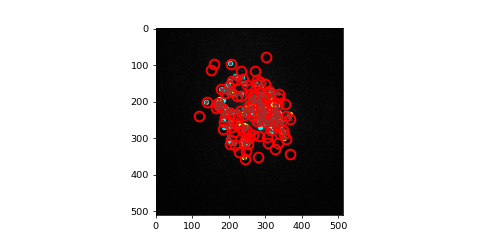

In [2]:
%matplotlib notebook
@pims.pipeline
def gray(image):
    return image[:,:, 1]  # Take just the green channel
frames= (pims.open('../Documents/more actin inhib/mouse wt 4/*.jpg'))

conect=4
mem=7
size=7
mass=100
filt=40
#tmMwt,dataMwt=find_traj_data(framesMwt,conect,mem,size,mass,filt)
#msd_Mwt,dt_Mwt=find_msd(tmMwt,40)
n=40
f = tp.locate(frames[n],size,minmass=mass)
tp.annotate(f, frames[n],plot_style={'markersize':10});
plt.imshow(frames[n])






In [6]:
tm,data=find_traj_data(frames,conect,mem,size,mass,filt)

ee,xe,ye,iid=find_ee_distance(tm)
x_cm,y_cm=find_cm(frames,tm,size)
x_cm=286
print(x_cm,y_cm)
ri,rf,iidr=find_rad_distance(tm,x_cm,y_cm)
ratio=in_out(4,ri,rf,xe,ye,ee,iidr,data,frames)  
data

data2=data

part_temp=list(data['particle'])
part = list(set(part_temp))
print(part)
data_temp=data
for i in part: ## loop over all trajectories
    
    df=data_temp.loc[data_temp['particle'] ==i]  ## dataframe of all rows with particle =i
    x_list=list(df['x'])## x positions of particle i
    y_list=list(df['y'])## y positions of particle i
    if np.sqrt((x_list[0]-x_cm)**2+(y_list[0]-y_cm)**2)<30:
        data_temp=data_temp[data_temp['particle']!=i]
    if np.sqrt((x_list[0]-x_list[-1])**2+(y_list[0]-y_list[-1])**2)<5:
        data_temp=data_temp[data_temp['particle']!=i]
    
data_temp   

part_temp=list(data_temp['particle'])
part = list(set(part_temp))

Frame 199: 56 features
286 229.69306831559095
[1, 2, 3, 4, 5, 6, 8, 10, 11, 522, 16, 19, 20, 21, 22, 23, 25, 26, 28, 31, 32, 34, 35, 36, 37, 38, 39, 1574, 42, 43, 45, 47, 48, 49, 50, 1075, 52, 565, 54, 1590, 56, 57, 58, 60, 61, 62, 63, 64, 67, 579, 69, 70, 72, 73, 74, 75, 76, 587, 78, 1104, 81, 82, 84, 85, 86, 88, 90, 91, 93, 94, 98, 99, 100, 101, 1123, 103, 1128, 109, 113, 115, 117, 118, 121, 126, 640, 129, 130, 131, 132, 133, 1671, 1673, 138, 143, 657, 147, 661, 156, 161, 1703, 179, 181, 186, 187, 188, 190, 715, 1230, 210, 211, 1242, 1245, 222, 737, 228, 1252, 230, 232, 1259, 1265, 1266, 245, 1271, 1274, 1276, 1278, 1282, 1293, 786, 1299, 277, 1303, 1317, 299, 1326, 304, 308, 328, 353, 1391, 373, 378, 384, 391, 392, 904, 396, 409, 937, 436, 446, 463, 472, 984, 502, 1014]


<IPython.core.display.Javascript object>


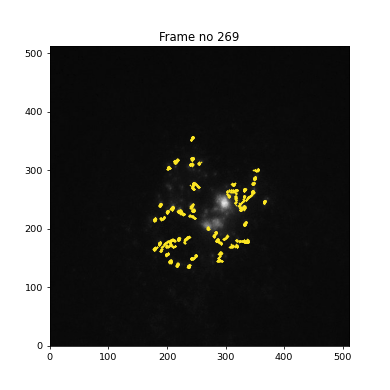

In [7]:
# GENERATE IMAGES FOR MOVIES. 
# SAVES THE IMAGES IN A FOLDER CALLED figs

fig,ax = plt.subplots(figsize=(8,8))

# print(cdict)|

x_store=[]
y_store=[]
colors = plt.cm.viridis(np.linspace(0, 1, 270))
for f in range(270):
    # Plot the actin density from the current frame
    frame_curr = frames[f]
    ax.cla()
    frame_curr = frame_curr/255
    ax.imshow(frame_curr,origin='lower',cmap="Greys_r",vmin=0,vmax=1)
    
    df=data_temp.loc[data_temp['frame'] ==f]
    x_list=df['x'].tolist()
    y_list=df['y'].tolist()
    for x,y in zip(x_list,y_list):
        x_store.append(x)
        y_store.append(y)
    
    ax.scatter(x_store,y_store,s=0.5,color=colors[f])
    
    ax.set_title("Frame no %03d"%f)
    plt.savefig("M_track1/frame_%03d.png"%f,bbox_inches="tight")
    
# fig.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 8))



colors = plt.cm.cool(np.linspace(0, 1, 270))

for f in range(270):
    print(f)
    ax.cla()
    frame_curr = frames[f] / 255
    ax.imshow(frame_curr, origin='lower', cmap="Greys_r", vmin=0, vmax=1)

    for prev_f in range(f):  # Plotting scatter plots from previous frames
        df_prev = data_temp.loc[data_temp['frame'] == prev_f]
        x_list_prev = df_prev['x'].tolist()
        y_list_prev = df_prev['y'].tolist()
        
        for x, y in zip(x_list_prev, y_list_prev):
            ax.scatter(x, y, s=0.7, color=colors[prev_f], alpha=0.5)  # Previous frames' scatter plots with some transparency
    
    df = data_temp.loc[data_temp['frame'] == f]
    x_list = df['x'].tolist()
    y_list = df['y'].tolist()

    # Assign a different color for the current frame
    for i, (x, y) in enumerate(zip(x_list, y_list)):
        x_store.append(x)
        y_store.append(y)
        ax.scatter(x, y, s=0.7, color=colors[f])  # Scatter plot for the current frame
    
    ax.set_title("Frame no %03d" % f)
    plt.savefig("M_track1/frame_%03d.png" % f, bbox_inches="tight")

plt.show()

<IPython.core.display.Javascript object>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
